In [2]:
# Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # Functipn to split data into training, validation and test sets
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import glob   # The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order. No tilde expansion is done, but *, ?, and character ranges expressed with [] will be correctly matched.
import os   # miscellneous operating system interfaces. This module provides a portable way of using operating system dependent functionality. If you just want to read or write a file see open(), if you want to manipulate paths, see the os.path module, and if you want to read all the lines in all the files on the command line see the fileinput module.
import random       
from tqdm import tqdm 
from tqdm.notebook import tqdm_notebook
import datetime
import time
from tabulate import tabulate

# Torch
import torch
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
import torchinfo
import torch.nn.functional as F


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve,log_loss
from sklearn.metrics import average_precision_score,roc_auc_score
import os
import time
from time import time
import datetime
import pandas as pd
import numpy as np
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from skmultilearn.adapt import MLkNN

# CMAP (extracting relevant transcriptomic profiles)
from cmapPy.pandasGEXpress.parse import parse
import cmapPy.pandasGEXpress.subset_gctoo as sg
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import time

In [3]:
from ML_battery_L1000 import tprofiles_gc_too_func, extract_tprofile, load_train_valid_data

In [4]:
using_cuda = True
hidden_size = 1024

In [5]:
# Downloading all relevant data frames and csv files ----------------------------------------------------------

# clue column metadata with columns representing compounds in common with SPECs 1 & 2
clue_sig_in_SPECS = pd.read_csv('/home/jovyan/Tomics-CP-Chem-MoA/04_Tomics_Models/init_data_expl/clue_sig_in_SPECS1&2.csv', delimiter = ",")

# clue row metadata with rows representing transcription levels of specific genes
clue_gene = pd.read_csv('/home/jovyan/Tomics-CP-Chem-MoA/04_Tomics_Models/init_data_expl/clue_geneinfo_beta.txt', delimiter = "\t")


In [6]:
def splitting_into_tensor(df, num_classes):
    '''Splitting data into two parts:
    1. input : the pointer showing where the transcriptomic profile is  
    2. target one hot : labels (the correct MoA) '''
    
    # one-hot encoding labels
     # creating tensor from all_data.df
    target = torch.tensor(df['moa'].values.astype(np.int64))

    # For each row, take the index of the target label
    # (which coincides with the score in our case) and use it as the column index to set the value 1.0.” 
    target_onehot = torch.zeros(target.shape[0], num_classes)
    target_onehot.scatter_(1, target.unsqueeze(1), 1.0)
    
    input =  df.drop('moa', axis = 1)
    
    return input, target_onehot


In [7]:
class Transcriptomic_Profiles(torch.utils.data.Dataset):
    def __init__(self, labels, gc_too):
        self.tprofile_labels = labels
        self.profiles_gc_too = gc_too
        
    def __len__(self):
        ''' The number of data points '''
        return len(self.tprofile_labels)

    def __getitem__(self, idx):
        '''Retreiving the transcriptomic profile and label'''
        t_profile = extract_tprofile(self.profiles_gc_too, idx)          # extract image from csv using index
        t_profile = torch.tensor(t_profile)       # turn t profile into a floating torch tensor
        label = self.tprofile_labels[idx]          # extract calssification using index
        return torch.squeeze(t_profile), torch.squeeze(label) 


In [8]:
batch_size = 50
WEIGHT_DECAY = 1e-5
learning_rate = 5e-3 
# parameters
params = {'batch_size' : batch_size,
         'num_workers' : 3,
         'shuffle' : True,
         'prefetch_factor' : 2} 
          
if using_cuda:
    device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
else:
    device = torch.device('cpu')
print(f'Training on device {device}. ' )


Training on device cuda. 


In [9]:
train_filename = 'L1000_training_set_cyclo_adr_2.csv'
valid_filename = 'L1000_test_set_cyclo_adr_2.csv'
L1000_training, L1000_validation = load_train_valid_data(train_filename, valid_filename)

In [10]:
# shuffling training and validation data 
# May not be necessary given params
L1000_training = L1000_training.sample(frac = 1, random_state = 1)
L1000_validation = L1000_validation.sample(frac = 1, random_state = 1)

In [11]:
L1000_training.head()

,Compound ID,sig_id,moa
133,CBK004363,LCP001_MCF10A.KRAS.HG_24H:B10,0
349,CBK041382,CPC011_VCAP_6H:BRD-K10670311-001-12-2:10,0
1036,CBK041944,CPC018_PHH_24H:BRD-A03623303-045-05-3:10,1
268,CBK016153,CPC004_PC3_6H:BRD-K12513978-001-16-7:10,0
899,CBK290222,CPC016_NEU_24H:BRD-A87479750-001-01-9:10,0


In [12]:
L1000_training["moa"].value_counts()

0    894
1    389
Name: moa, dtype: int64

In [13]:
L1000_validation.head()

,Compound ID,sig_id,moa
358,CBK041406,CPC005_A549_24H:BRD-K46211610-003-15-0:10,1
164,CBK011617,LIVB001_HUH7_72H:B16,0
17,CBK290981,CPC006_CORL23_6H:BRD-K12994359-001-07-7:177.6,0
67,CBK290981,CPC006_NOMO1_6H:BRD-K12994359-001-07-7:177.6,0
4,CBK290981,CPC006_SW620_6H:H02,0


In [14]:
L1000_validation["moa"].value_counts()

0    290
1    128
Name: moa, dtype: int64

In [15]:
profiles_gc_too_train = tprofiles_gc_too_func(L1000_training, clue_gene)
profiles_gc_too_valid = tprofiles_gc_too_func(L1000_validation, clue_gene)


In [16]:
L1000_training.columns

Index(['Compound ID', 'sig_id', 'moa'], dtype='object')

In [17]:
num_classes = len(L1000_training["moa"].unique())
num_classes

2

In [18]:
# splitting
input_df_val, labels_train = splitting_into_tensor(L1000_training, num_classes) 
input_df_val, labels_val = splitting_into_tensor(L1000_validation, num_classes) 

In [19]:
# generator: training
# create a subset with only train indices

# create generator that randomly takes indices from the training set
training_dataset = Transcriptomic_Profiles(labels_train, profiles_gc_too_train)



training_generator = torch.utils.data.DataLoader(training_dataset, **params)



In [20]:
# generator: validation
# create a subset with only valid indices

# create generator that randomly takes indices from the validation set
validation_dataset = Transcriptomic_Profiles(labels_val, profiles_gc_too_valid)



validation_generator = torch.utils.data.DataLoader(validation_dataset, **params)



In [21]:
train_profile, train_labels = next(iter(training_generator))



In [22]:
train_profile

tensor([[ 0.2102, -0.6772, -0.5527,  ...,  0.6463, -0.6224, -1.0164],
        [-0.9024,  2.0847,  0.0076,  ...,  0.3009,  0.1045, -0.2208],
        [-5.4819, -2.3780,  0.8990,  ..., -0.7983,  0.0737, -0.9017],
        ...,
        [-0.0179,  0.2595, -0.1286,  ...,  0.6645,  0.0750,  0.0646],
        [ 0.4010,  0.5181,  0.2431,  ...,  0.3165,  0.7806, -0.2596],
        [-0.1564,  0.5546,  0.4146,  ...,  0.2178,  0.9820,  0.1740]])

In [23]:
print(f'profile: {train_profile}, train label: {train_labels}')

profile: tensor([[ 0.2102, -0.6772, -0.5527,  ...,  0.6463, -0.6224, -1.0164],
        [-0.9024,  2.0847,  0.0076,  ...,  0.3009,  0.1045, -0.2208],
        [-5.4819, -2.3780,  0.8990,  ..., -0.7983,  0.0737, -0.9017],
        ...,
        [-0.0179,  0.2595, -0.1286,  ...,  0.6645,  0.0750,  0.0646],
        [ 0.4010,  0.5181,  0.2431,  ...,  0.3165,  0.7806, -0.2596],
        [-0.1564,  0.5546,  0.4146,  ...,  0.2178,  0.9820,  0.1740]]), train label: tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
   

In [24]:
train_profile.shape[1]

978

In [25]:
valid_profile, valid_labels = next(iter(validation_generator))

In [26]:
print(f'profile: {valid_profile}, train label: {valid_labels}')

profile: tensor([[ 0.1450, -0.5532, -1.0051,  ...,  2.0738,  0.4996, -0.1193],
        [-0.8692,  0.8690,  1.6033,  ...,  0.5633,  0.9441, -0.0739],
        [-2.0174,  0.2177,  0.1947,  ..., -0.0871, -0.0122, -1.9245],
        ...,
        [ 0.1068,  0.4535,  0.3614,  ..., -0.8379,  0.3471,  0.6554],
        [ 0.6692,  1.0530, -0.0680,  ...,  1.1166, -0.2148,  1.5593],
        [-0.4435,  1.1193,  1.4305,  ...,  1.4778,  1.5503, -0.3528]]), train label: tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
   

In [27]:
class SimpleNN_Model(nn.Module):
    """
    Simple 3-Layer FeedForward Neural Network
    
    For more info: https://github.com/guitarmind/kaggle_moa_winner_hungry_for_gold\
    /blob/main/final/Best%20LB/Training/3-stagenn-train.ipynb
    """
    def __init__(self, num_features = None, num_targets = None, hidden_size = None):
        super(SimpleNN_Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(0.25)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.3)
        self.dense2 = nn.Linear(hidden_size, hidden_size)
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.3)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

In [28]:
model = SimpleNN_Model(num_features = train_profile.shape[1], num_targets= num_classes, hidden_size= hidden_size)
optimizer = torch.optim.Adam(model.parameters(),  weight_decay=WEIGHT_DECAY, lr=learning_rate)
loss_fn = torch.nn.BCEWithLogitsLoss()


In [29]:
# ----------------------------------------- hyperparameters ---------------------------------------#
# Hyperparameters
testing = False # decides if we take a subset of the data
max_epochs = 50 # number of epochs we are going to run 
# apply_class_weights = True # weight the classes based on number of compounds
using_cuda = True # to use available GPUs
world_size = torch.cuda.device_count()

#----------------------------------------- pre-processing -----------------------------------------#
start = time.time()
now = datetime.datetime.now()
now = now.strftime("%d_%m_%Y-%H:%M:%S")
print("Begin Training")

Begin Training


In [30]:
# --------------------------Function to perform training, validation, testing, and assessment ------------------


def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, valid_loader):
    '''
    n_epochs: number of epochs 
    optimizer: optimizer used to do backpropagation
    model: deep learning architecture
    loss_fn: loss function
    train_loader: generator creating batches of training data
    valid_loader: generator creating batches of validation data
    '''
    # lists keep track of loss and accuracy for training and validation set
    model = model.to(device)
    train_loss_per_epoch = []
    train_acc_per_epoch = []
    val_loss_per_epoch = []
    val_acc_per_epoch = []
    best_val_loss = np.inf
    for epoch in tqdm(range(1, max_epochs +1), desc = "Epoch", position=0, leave= True):
        loss_train = 0.0
        train_total = 0
        train_correct = 0
        for tprofiles, labels in train_loader:
            optimizer.zero_grad()
            # put model, images, labels on the same device
            tprofiles = tprofiles.to(device = device)
            labels = labels.to(device= device)
            # Training Model
            outputs = model(tprofiles)
            #print(f' Outputs : {outputs}') # tensor with 10 elements
            #print(f' Labels : {labels}') # tensor that is a number
            loss = loss_fn(outputs,labels)
            # For L2 regularization
            #l2_lambda = 0.000001
            #l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            #loss = loss + l2_lambda * l2_norm
            # Update weights
            loss.backward()
            optimizer.step()
            # Training Metrics
            loss_train += loss.item()
            #print(f' loss: {loss.item()}')
            train_predicted = torch.argmax(outputs, 1)
            #print(f' train_predicted {train_predicted}')
            # NEW
            labels = torch.argmax(labels,1)
            #print(labels)
            train_total += labels.shape[0]
            train_correct += int((train_predicted == labels).sum())
        # validation metrics from batch
        val_correct, val_total, val_loss, best_val_loss_upd = validation_loop(model, loss_fn, valid_loader, best_val_loss)
        best_val_loss = best_val_loss_upd
        val_accuracy = val_correct/val_total
        # printing results for epoch
        if epoch == 1 or epoch %5 == 0:
            print(f' {datetime.datetime.now()} Epoch: {epoch}, Training loss: {loss_train/len(train_loader)}, Validation Loss: {val_loss} ')
        # adding epoch loss, accuracy to lists 
        val_loss_per_epoch.append(val_loss)
        train_loss_per_epoch.append(loss_train/len(train_loader))
        val_acc_per_epoch.append(val_accuracy)
        train_acc_per_epoch.append(train_correct/train_total)
    # return lists with loss, accuracy every epoch
    return train_loss_per_epoch, train_acc_per_epoch, val_loss_per_epoch, val_acc_per_epoch
                                

def validation_loop(model, loss_fn, valid_loader, best_val_loss):
    '''
    Assessing trained model on valiidation dataset 
    model: deep learning architecture getting updated by model
    loss_fn: loss function
    valid_loader: generator creating batches of validation data
    '''
    model = model.to(device)
    model.eval()
    loss_val = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # does not keep track of gradients so as to not train on validation data.
        for tprofiles, labels in valid_loader:
            # Move to device MAY NOT BE NECESSARY
            tprofiles = tprofiles.to(device = device)
            labels = labels.to(device= device)
            # Assessing outputs
            outputs = model(tprofiles)
            loss = loss_fn(outputs,labels)
            loss_val += loss.item()
            predicted = torch.argmax(outputs, 1)
            labels = torch.argmax(labels,1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
        avg_val_loss = loss_val/len(valid_loader)  # average loss over batch
        if best_val_loss > avg_val_loss:
            best_val_loss = avg_val_loss
            torch.save(
                {
                    'model_state_dict' : model.state_dict(),
                    'valid_loss' : loss_val
            },  '/home/jovyan/Tomics-CP-Chem-MoA/04_Tomics_Models/Best_Tomics_Model/saved_models' +'/' + 'Tomics_SimpleNN'
            )
    model.train()
    return correct, total, avg_val_loss, best_val_loss

#---------------------------------------- Visual Assessment ---------------------------------# 

def val_vs_train_loss(epochs, train_loss, val_loss):
    ''' 
    Plotting validation versus training loss over time
    epochs: number of epochs that the model ran (int. hyperparameter)
    train_loss: training loss per epoch (python list)
    val_loss: validation loss per epoch (python list)
    ''' 
    loss_path_to_save = '/home/jovyan/Tomics-CP-Chem-MoA/04_Tomics_Models/Best_Tomics_Model/saved_images'
    plt.figure()
    x_axis = list(range(1, epochs +1)) # create x axis with number of
    plt.plot(x_axis, train_loss, label = "train_loss")
    plt.plot(x_axis, val_loss, label = "val_loss")
    # Figure description
    plt.xlabel('# of Epochs')
    plt.ylabel('Loss')
    plt.title('Validation versus Training Loss: Tomics SimpleNN Model')
    plt.legend()
    # plot
    plt.savefig(loss_path_to_save + '/' + 'loss_train_val_simpleNN' + now)


def val_vs_train_accuracy(epochs, train_acc, val_acc):
    '''
    Plotting validation versus training loss over time
    epochs: number of epochs that the model ran (int. hyperparameter)
    train_acc: accuracy loss per epoch (python list)
    val_acc: accuracy loss per epoch (python list)
    '''
    acc_path_to_save = '/home/jovyan/Tomics-CP-Chem-MoA/04_Tomics_Models/Best_Tomics_Model/saved_images'
    plt.figure()
    x_axis = list(range(1, epochs +1)) # create x axis with number of
    plt.plot(x_axis, train_acc, label = "train_acc")
    plt.plot(x_axis, val_acc, label = "val_acc")
    # Figure description
    plt.xlabel('# of Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation versus Training Accuracy: Tomics SimpleNN Model')
    plt.legend()
    # plot
    plt.savefig(acc_path_to_save + '/' + 'acc_train_val_simpleNN' + now)



In [33]:
train_loss_per_epoch, train_acc_per_epoch, val_loss_per_epoch, val_acc_per_epoch = training_loop(n_epochs = max_epochs,
              optimizer = optimizer,
              model = model,
              loss_fn = loss_fn,
              train_loader=validation_generator, 
              valid_loader=training_generator)

Epoch:   2%|▏         | 1/50 [00:02<02:16,  2.79s/it]

 2023-01-26 10:29:35.131949 Epoch: 1, Training loss: 1.8633783260981243, Validation Loss: 0.046285590586753994 


Epoch:  10%|█         | 5/50 [00:14<02:06,  2.80s/it]

 2023-01-26 10:29:46.361838 Epoch: 5, Training loss: 0.22218404875861275, Validation Loss: 0.32060902279156905 


Epoch:  20%|██        | 10/50 [00:27<01:51,  2.78s/it]

 2023-01-26 10:30:00.235836 Epoch: 10, Training loss: 0.06421460087100665, Validation Loss: 0.32533287457548654 


Epoch:  30%|███       | 15/50 [00:42<01:38,  2.83s/it]

 2023-01-26 10:30:14.367351 Epoch: 15, Training loss: 0.048771308890233435, Validation Loss: 0.47089989254107845 


Epoch:  40%|████      | 20/50 [00:55<01:22,  2.76s/it]

 2023-01-26 10:30:28.103569 Epoch: 20, Training loss: 0.02934030702130662, Validation Loss: 0.42673947604802936 


Epoch:  50%|█████     | 25/50 [01:09<01:08,  2.76s/it]

 2023-01-26 10:30:41.953078 Epoch: 25, Training loss: 0.023035837182154257, Validation Loss: 0.5894661797926977 


Epoch:  60%|██████    | 30/50 [01:23<00:54,  2.72s/it]

 2023-01-26 10:30:55.506112 Epoch: 30, Training loss: 0.051390350692802005, Validation Loss: 0.6633964169483918 


Epoch:  70%|███████   | 35/50 [01:37<00:41,  2.76s/it]

 2023-01-26 10:31:09.353373 Epoch: 35, Training loss: 0.021013858158969216, Validation Loss: 0.6165892120737296 


Epoch:  80%|████████  | 40/50 [01:50<00:27,  2.75s/it]

 2023-01-26 10:31:23.026057 Epoch: 40, Training loss: 0.02510971912286348, Validation Loss: 0.6641331509901927 


Epoch:  90%|█████████ | 45/50 [02:04<00:13,  2.74s/it]

 2023-01-26 10:31:36.760036 Epoch: 45, Training loss: 0.038094143021023937, Validation Loss: 0.7024673773692205 


Epoch: 100%|██████████| 50/50 [02:18<00:00,  2.76s/it]

 2023-01-26 10:31:50.503986 Epoch: 50, Training loss: 0.022983290099849302, Validation Loss: 0.7767477665956204 


1644.87
╒═════════════════════╤════════════════════════╕
│ Time to Run Program │ 27.414499999999997 min │
╘═════════════════════╧════════════════════════╛


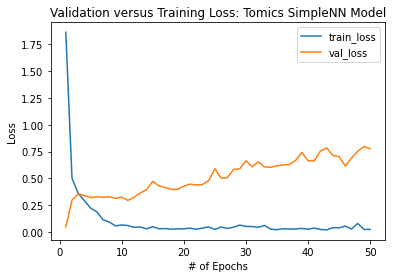

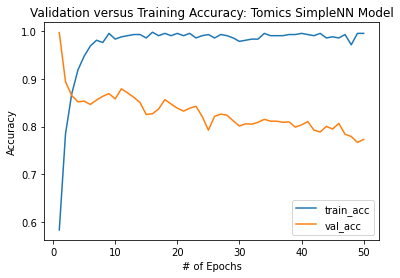

In [34]:
val_vs_train_loss(max_epochs,train_loss_per_epoch, val_loss_per_epoch)
val_vs_train_accuracy(max_epochs, train_acc_per_epoch, val_acc_per_epoch)

#-------------------------------- Writing interesting info into terminal ------------------------# 

end = time.time()
def program_elapsed_time(start, end):
    program_time = round(end - start, 2) 
    print(program_time)
    if program_time > float(60) and program_time < 60*60:
        program_time =  program_time/60
        time_elapsed = str(program_time) + ' min'
    elif program_time > 60*60:
        program_time = program_time/3600
        time_elapsed = str(program_time) + ' hrs'
    else:
        time_elapsed = str(program_time) + ' sec'
    return time_elapsed
program_elapsed_time = program_elapsed_time(start, end)

#test_set_acc = f' {round(correct/total*100, 2)} %'
table = [["Time to Run Program", program_elapsed_time]]
#['Accuracy of Test Set', test_set_acc]]
print(tabulate(table, tablefmt='fancy_grid'))

